In [1]:
import re
from math import sqrt, floor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains

# Question 1

In [2]:
# Import Auto.csv (also, iris)
auto = pd.read_csv("Auto.csv")
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [3]:
# Check the data types of each column
auto.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

In [4]:
# Try to recode horsepower as numeric (pd.to_numeric or Series.astype)
auto["horsepower"] = auto["horsepower"].astype("int64") # ERROR
# Alternatively:
# auto["horsepower"] = auto["horsepower"].pipe(pd.to_numeric) # ERROR

ValueError: invalid literal for int() with base 10: '?'

In [5]:
# Print weird elements
_ = auto["horsepower"].apply(lambda x: x if x.isnumeric() else print(x))

?
?
?
?
?


In [6]:
# Replace erroneous data points with pd.NA types
auto["horsepower"] = auto["horsepower"].pipe(pd.to_numeric, errors="coerce")
# Alternatively:
# auto["horsepower"].apply(lambda x: x if x.isnumeric() else pd.NA).pipe(to_numeric)

In [7]:
## a)
auto.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')

In [8]:
non_predictors = ["mpg"]
quant_predictors = ["cylinders", "displacement", "horsepower", "weight", "acceleration", "year"]
quali_predictors = ["origin", "name"]

In [9]:
## b,c)
# Subset columns and describe them
auto[quant_predictors].describe()

,cylinders,displacement,horsepower,weight,acceleration,year
count,397.000000,397.000000,392.000000,397.000000,397.000000,397.000000
mean,5.458438,193.532746,104.469388,2970.261965,15.555668,75.994962
std,1.701577,104.379583,38.491160,847.904119,2.749995,3.690005
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,4.000000,104.000000,75.000000,2223.000000,13.800000,73.000000
50%,4.000000,146.000000,93.500000,2800.000000,15.500000,76.000000
75%,8.000000,262.000000,126.000000,3609.000000,17.100000,79.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


In [10]:
## d)
# Drop observations 10 through 85 and find min, max, mean, and std
auto.drop(range(10, 86), axis=0)[quant_predictors].describe()
# Alternatively:
# pd.concat([auto.iloc[0:10], auto.iloc[86:]])

,cylinders,displacement,horsepower,weight,acceleration,year
count,321.000000,321.000000,317.000000,321.000000,321.000000,321.000000
mean,5.370717,187.174455,101.003155,2933.183801,15.709034,77.143302
std,1.653486,99.864568,36.003208,809.638650,2.706441,3.128202
min,3.000000,68.000000,46.000000,1649.000000,8.500000,70.000000
25%,4.000000,100.000000,75.000000,2215.000000,14.000000,75.000000
50%,4.000000,145.000000,90.000000,2795.000000,15.500000,77.000000
75%,6.000000,250.000000,115.000000,3504.000000,17.300000,80.000000
max,8.000000,455.000000,230.000000,4997.000000,24.800000,82.000000


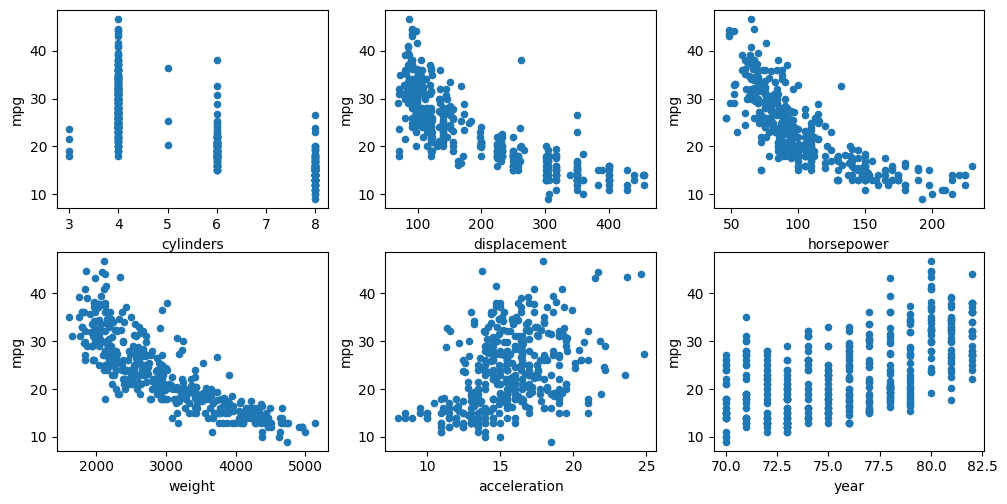

In [11]:
## e)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,5))
fig.tight_layout()

for qp, ax in zip(quant_predictors, axs.reshape(-1)):
    auto.plot(x=qp, y="mpg", kind="scatter", ax=ax)

# Question 2

In [12]:
# This code shows that polynomials with higher degrees are more flexible and 
# so can fit the training data better

# NOTE: This section is more an aide to the discussion around question 2
# Rather than an answer to the question on it's own

def poly_fit(a, b, std=1, n=10, degrees=None):

    # Why do this when we could have done degrees=[1,2,3]?
    if degrees is None:
        degrees = [1,2,3]
    
    x = np.arange(1, n+1)
    y_true = a + b*x
    y = y_true + np.random.normal(0, std, n)

    # non-mutating
    degrees = degrees + [n]

    ndeg = len(degrees)
    nrows = floor(sqrt(ndeg))
    ncols = ndeg // nrows

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                            figsize=tuple([n*4 for n in [nrows, ncols]]))
    fig.tight_layout()

    for deg, ax in zip(degrees, axs.reshape(-1)):
        
        coeffs = np.polyfit(x, y, deg)
        # What's happening here?
        # How can we explore what np.poly1d is doing?
        poly_fit = np.poly1d(coeffs)(x)
        ssr = ((np.array([y, y_true]) - poly_fit)**2).sum(axis=1)
        
        ax.plot(x, y_true, "o", c="black", label="$y_{true}$")
        ax.plot(x, y, "o", label="y")
        # Why so many curly braces?
        ax.plot(x, poly_fit, label=f"$P_{{{deg}}}$ fit")
        ax.legend()
        ax.set_title(f"SSR[y y_true] = {ssr}", size=8)
    
    return fig, axs

/tmp/ipykernel_161630/3364424061.py:30: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg)


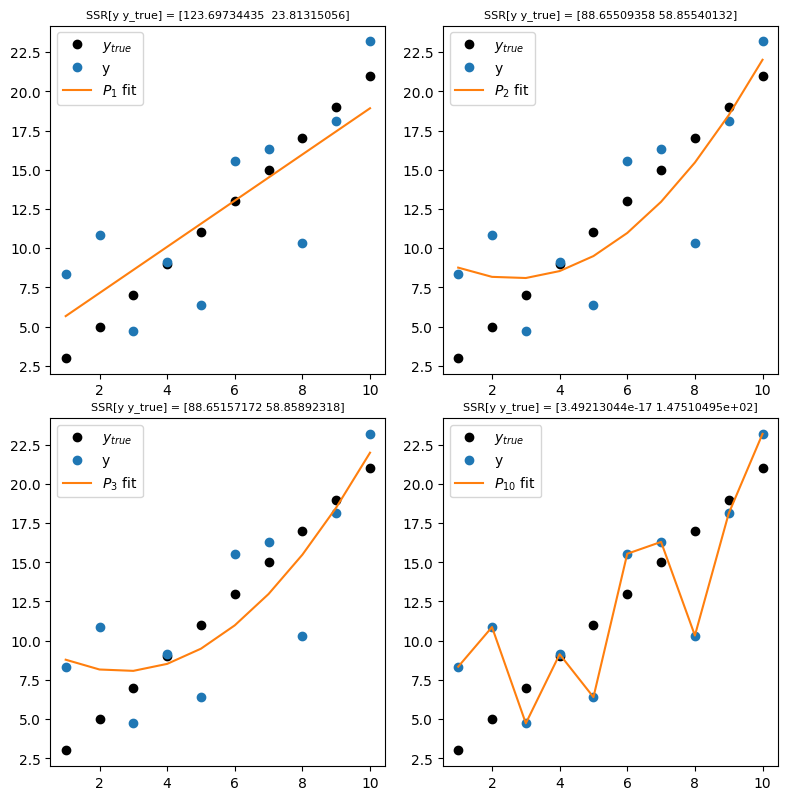

In [13]:
_ = poly_fit(1, 2, std=5, n=10)

# Question 3

In [14]:
driver = webdriver.Chrome()
a = ActionChains(driver)

In [29]:
driver.get("https://finance.yahoo.com/")

In [30]:
elems = driver.find_elements(By.LINK_TEXT, "News")
elems

[<selenium.webdriver.remote.webelement.WebElement (session="812f1a73d1a0a348b333f8628125557e", element="E7736AE010F1A09A43A3F6A25CA98BBF_element_142")>,
 <selenium.webdriver.remote.webelement.WebElement (session="812f1a73d1a0a348b333f8628125557e", element="E7736AE010F1A09A43A3F6A25CA98BBF_element_143")>]

In [31]:
dir(elems[0])

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_execute',
 '_id',
 '_parent',
 '_upload',
 'accessible_name',
 'aria_role',
 'clear',
 'click',
 'find_element',
 'find_elements',
 'get_attribute',
 'get_dom_attribute',
 'get_property',
 'id',
 'is_displayed',
 'is_enabled',
 'is_selected',
 'location',
 'location_once_scrolled_into_view',
 'parent',
 'rect',
 'screenshot',
 'screenshot_as_base64',
 'screenshot_as_png',
 'send_keys',
 'shadow_root',
 'size',
 'submit',
 'tag_name',
 'text',
 'value_of_css_property']

In [32]:
for i, elem in enumerate(elems):
    elem.screenshot(f"ss{i}.png")

In [33]:
a.move_to_element(elems[1]).perform()
elem = driver.find_element(By.LINK_TEXT, "Latest News")
elem.click()

In [34]:
elem = driver.find_element(By.CLASS_NAME, "StretchedBox")
elem.click()

In [41]:
elem = driver.find_element(By.ID, "Fin-Stream")
elems = elem.find_elements(By.XPATH, ".//*")

In [42]:
title = driver.title

I = len(elems)
text = ''
for i, elem in enumerate(elems):
    try:
        elem.find_element(By.CLASS_NAME, "Cf")
        text += elem.text
        print(f"{i}/{I}", end='\r')
    except:
        pass

print(text)

BusinessReuters•8 minutes ago
J.P.Morgan now expects BoE to start cutting interest rates in August
The brokerage now expects a 75-basis point rate cut by end 2024, taking J.P.Morgan's policy rate forecast to 4.5%, while the central bank's current benchmark rate stands at 5.25%. J.P.Morgan had earlier estimated BoE to start cutting rates only in November. The easing in consumer prices had led many economists to predict that it would be back at the BoE's 2% target by April or May this year, around 18 months sooner than the BoE was predicting.
You might also like
UK wage growth slowdown hints at possible BoE interest rate cut
Yahoo Finance UK
UK Bonds Tumble as Inflation Pickup Fuels Repricing in Rate Bets
Bloomberg
FTSE 100 Live: HSBC cuts mortgage interest rates ahead of big week for BoE; LSEG defiant as six held for ‘plot to disrupt trading’
Evening Standard
Watch This Lithium Stock Now
microcapwatch.comAd
Inflation takes centre stage as City braces for clues on Bank of England interes